In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def base_metrics(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

In [4]:
def profit(cm, income_per_person = 2, expense_per_person = 1):
    #return (cm[0,0] + cm[1,0]) * income_per_person - cm[0,1] * income_per_person - np.sum(cm) * expense_per_person
    #return (cm[0,0] + cm[1,0]) * income_per_person - np.sum(cm) * expense_per_person
    #TP * 2 - (TP + FP) * 1 + TN * 1 - FN * 2
    return (cm[0,0]) * income_per_person - (cm[0,0] + cm[0,1])* expense_per_person - cm[1,0] * income_per_person

# Урок 5. Задача оттока: варианты постановки, возможные способы решения

### Домашнее задание
1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

набор данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [5]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [6]:
# new features
df['NumOfActiveProducts'] = df['IsActiveMember'] * df['NumOfProducts']
df['ProductBalance'] = df['Balance'] / df['NumOfProducts']
df['NumberOfSalariesInBalance'] = df['Balance'] / df['EstimatedSalary']
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NumOfActiveProducts,ProductBalance,NumberOfSalariesInBalance
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0.000000,0.000000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,83807.860000,0.744677
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,53220.266667,1.401375


Посмотрим на распределение классов:

In [7]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [8]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=12)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [9]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [10]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NumOfActiveProducts,ProductBalance,NumberOfSalariesInBalance
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0.000000,0.000000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,83807.860000,0.744677
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,53220.266667,1.401375


Зададим списки признаков

In [11]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember', 'NumOfActiveProducts']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'ProductBalance', 'NumberOfSalariesInBalance']

Трансформируем признаки в цикле

In [12]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('log_scale', FunctionTransformer(np.log1p)),
                ('standard', StandardScaler())
                 ])
    """cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
                 ])"""
    final_transformers.append((cont_col, cont_transformer))

In [13]:
#final_transformers

Объединим все это в единый пайплайн

In [14]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

### RandomForestClassifier

In [15]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

"""
RandomForestClassifier(n_estimators=200, max_depth=9, min_samples_split=3, min_samples_leaf=3, random_state=12)
LogisticRegression(penalty='elasticnet', tol=0.00001, random_state=12, 
                                      solver='saga', max_iter=300, l1_ratio=0.3)
GradientBoostingClassifier(learning_rate=0.05, n_estimators=150, criterion='friedman_mse', 
                                              min_samples_split=4, min_samples_leaf=3, max_depth=9, 
                                              random_state=12)
"""
pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=9, min_samples_split=3, min_samples_leaf=3, random_state=12)),
])

Обучим модель

In [16]:
#обучим наш пайплайн
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [17]:
#наши прогнозы для тестовой выборки
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]
preds_rf[:10]

array([0.0412241 , 0.06782866, 0.3168657 , 0.07376682, 0.54728346,
       0.10227526, 0.050297  , 0.11775773, 0.61154655, 0.06568272])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [18]:
models_metrics_data = np.array(([]))

In [19]:
models_metrics_data = np.append(models_metrics_data, 'RandomForestClassifier')
models_metrics_data = np.append(models_metrics_data, np.round(base_metrics(y_test, preds_rf),3))

#base_metrics(y_test, preds_rf)

Best Threshold=0.336390, F-Score=0.656, Precision=0.733, Recall=0.594


### GradientBoostingClassifier

In [20]:
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.05, n_estimators=150, criterion='friedman_mse', 
                                              min_samples_split=4, min_samples_leaf=3, max_depth=9, 
                                              random_state=12)),
])
pipeline_gb.fit(X_train, y_train)
#прогнозы для тестовой выборки
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]
preds_gb[:10]

array([0.0355961 , 0.02101053, 0.63109901, 0.04520312, 0.6336224 ,
       0.02387803, 0.02056656, 0.04691531, 0.9294759 , 0.05829371])

In [21]:
models_metrics_data = np.append(models_metrics_data, 'GradientBoostingClassifier')
models_metrics_data = np.append(models_metrics_data, np.round(base_metrics(y_test, preds_gb),3))

Best Threshold=0.307846, F-Score=0.634, Precision=0.667, Recall=0.604


### LogisticRegression

In [22]:
pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(penalty='elasticnet', tol=0.00001, random_state=12, 
                                      solver='saga', max_iter=100, l1_ratio=0.5)),
])
pipeline_lr.fit(X_train, y_train)
#прогнозы для тестовой выборки
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]
preds_lr[:10]

/Users/ivanbovsunovskii/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


array([0.03315936, 0.08559863, 0.33716938, 0.03896008, 0.5875882 ,
       0.21438879, 0.12460741, 0.33050399, 0.70461435, 0.0680865 ])

In [23]:
models_metrics_data = np.append(models_metrics_data, 'LogisticRegression')
models_metrics_data = np.append(models_metrics_data, np.round(base_metrics(y_test, preds_lr),3))

Best Threshold=0.242205, F-Score=0.581, Precision=0.504, Recall=0.685


In [24]:
models_metrics_data = np.reshape(models_metrics_data, (-1, 5))

In [25]:
models_metrics_data

array([['RandomForestClassifier', '0.336', '0.656', '0.733', '0.594'],
       ['GradientBoostingClassifier', '0.308', '0.634', '0.667', '0.604'],
       ['LogisticRegression', '0.242', '0.581', '0.504', '0.685']],
      dtype='<U32')

In [26]:
models_metrics_data[0,1]

'0.336'

In [27]:
plt.rcParams["figure.figsize"] = [16, 2]

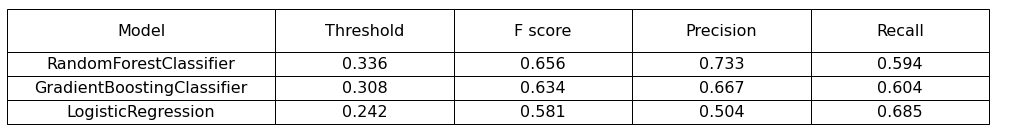

In [28]:
columns = ['Model', 'Threshold', 'F score', 'Precision', 'Recall']

fig, ax = plt.subplots()
#plt.rcParams["figure.figsize"] = [16, 2]

the_table = plt.table(cellText=models_metrics_data, cellLoc='center', rowLoc='right', 
                      colLabels=columns, loc=0, edges='closed')

for r in range(0, len(columns)):
    cell = the_table[0, r]
    cell.set_height(0.4)

for c in range(0, len(columns)):
    for r in range(1, 4):
        cell = the_table[r, c]
        cell.set_height(0.22)
    
for r in range(0, 4):
    cell = the_table[r, 0]
    cell.set_width(0.3)

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
#the_table.scale(2, 5)

plt.show()

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

1. Какова их взаимосвязь и как с ними связан порог вероятности?

2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
 можно порог стремится к 0, precision стремится к 0
3. Аналогичный вопрос про precision 
 порог стремится к 1, recall стремится к 0

Матрицы ошибок для разных методов

In [29]:
preds = np.array((preds_rf,preds_gb, preds_lr))

Profit for RandomForestClassifier method - 1250
Confusion matrix, without normalization
[[1823  121]
 [ 226  330]]


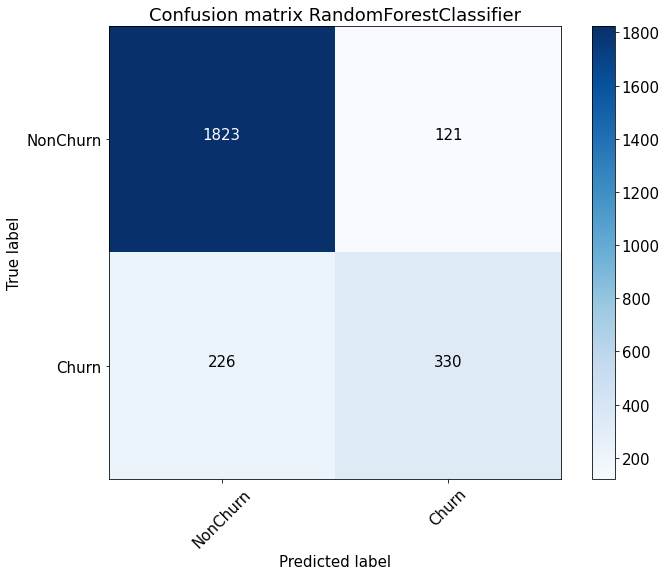

Profit for GradientBoostingClassifier method - 1166
Confusion matrix, without normalization
[[1776  168]
 [ 221  335]]


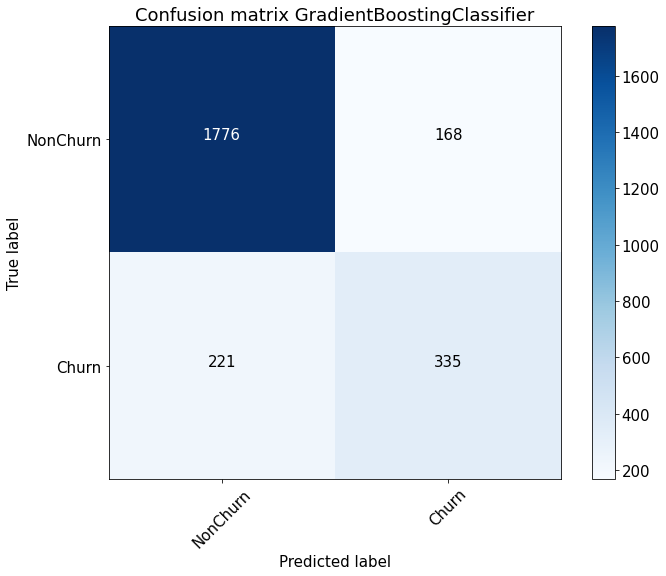

Profit for LogisticRegression method - 842
Confusion matrix, without normalization
[[1568  376]
 [ 175  381]]


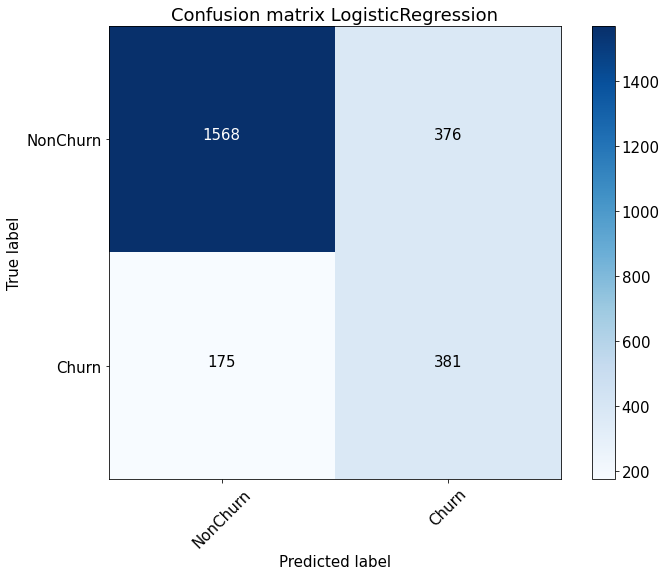

In [30]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)
for index in range(models_metrics_data.shape[0]):
    cnf_matrix = confusion_matrix(y_test, preds[index]>float(models_metrics_data[index,1]))
    print(f'Profit for {models_metrics_data[index,0]} method - {profit(cnf_matrix)}')
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                          title='Confusion matrix ' + models_metrics_data[index,0])
    plt.savefig("conf_matrix.png")
    plt.show()

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Очевидно требуется максимизировать прибыль, но предсказанную прибыль, с учетом предсказанных понесенных и не понесенных(+) затрат. Но в пределе прибыль будет максимальной если все предсказанные пользователи будут отнесены к классу - NonChurn. Поэтому чтобы учесть влияние сильного дисбаланса классов можно предсказанную прибыль выразить в виде TP * 2 - (TP + FP) * 1 + TN * 1 - FN * 2
в случае с TN - не потраченное = заработанное и наоборот в случае с FN

Тогда прибыль по методам будет:

In [33]:
for index in range(models_metrics_data.shape[0]):
    cnf_matrix = confusion_matrix(y_test, preds[index]>float(models_metrics_data[index,1]))
    print(f'Profit for {models_metrics_data[index,0]} method - {profit(cnf_matrix)}')

Profit for RandomForestClassifier method - 1250
Profit for GradientBoostingClassifier method - 1166
Profit for LogisticRegression method - 842


### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [36]:
from sklearn.model_selection import GridSearchCV

params={'classifier__n_estimators':[100, 150, 200],
        'classifier__max_features':[0.5, 0.7, 1],
        'classifier__min_samples_split':[2,3,4,5],
        'classifier__min_samples_leaf':[2, 3, 4, 5],
        'classifier__max_depth':[7, 8, 9, 10]
        }
params={'classifier__n_estimators':[80, 90, 100],
        'classifier__max_features':[0.35, 0.4, 0.45],
        'classifier__min_samples_split':[2,3],
        'classifier__min_samples_leaf':[4, 5, 6],
        'classifier__max_depth':[8, 9]
        
        }
#'classifier__random_state':[10, 11, 12, 13]

Запускаем перебор

In [37]:
grid = GridSearchCV(pipeline_rf,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': 9,
 'classifier__max_features': 0.4,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 90}

In [ ]:
"""{'classifier__max_depth': 10,
 'classifier__max_features': 0.5,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 100}
 
 {'classifier__max_depth': 9,
 'classifier__max_features': 0.4,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 100}
 
 {'classifier__max_depth': 9,
 'classifier__max_features': 0.4,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 90}
 """

Обучаем модель с оптимальными параметрами

In [38]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=90, max_depth=9, max_features=0.4, 
                                          min_samples_leaf=5, min_samples_split=2, random_state=12)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.407194, F-Score=0.640, Precision=0.756, Recall=0.556, with max profit=1252
Confusion matrix, without normalization
[[1845   99]
 [ 247  309]]


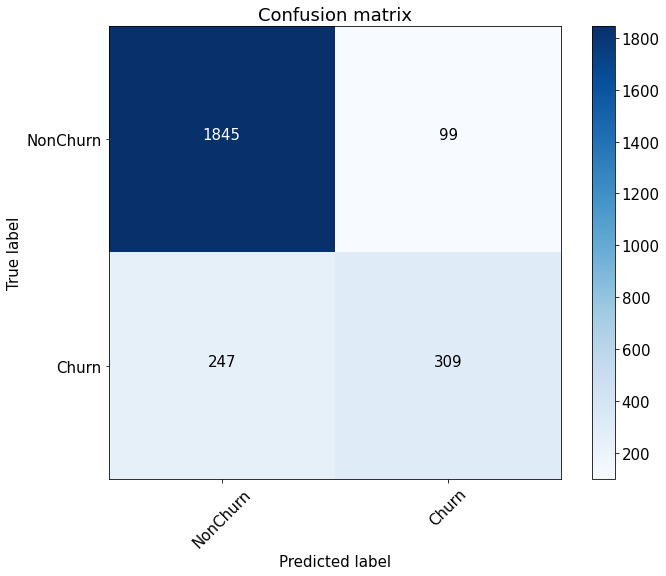

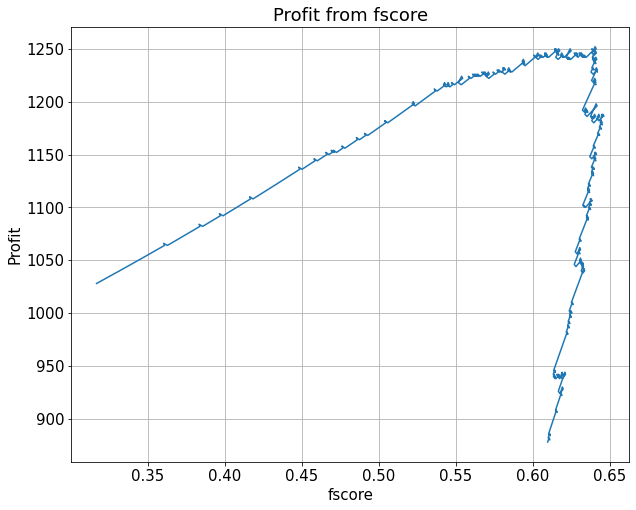

In [44]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
# and max profit
step_low = 300
step_high = 400
a = [profit(confusion_matrix(y_test, preds>thresholds[iy])) for iy in range(np.argmax(fscore)-step_low,np.argmax(fscore)+step_high)]
"""print(np.max(a), np.argmax(fscore)-step_low + np.argmax(a))
print(profit(confusion_matrix(y_test, preds>thresholds[np.argmax(fscore)-step_low + np.argmax(a)])))
print(np.argmax(fscore)-step_low, np.argmax(fscore)+step_high)
print(np.argmax(fscore)-step_low + np.argmax(a), thresholds[np.argmax(fscore)-step_low + np.argmax(a)])"""

ix = np.argmax(fscore)-step_low + np.argmax(a)

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, with max profit=%.0f' % (thresholds[ix], 
                                                                                              fscore[ix],
                                                                                              precision[ix],
                                                                                              recall[ix],
                                                                                              a[np.argmax(a)]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(fscore[np.argmax(fscore)-step_low:np.argmax(fscore)+step_high], a)
plt.title('Profit from fscore')
plt.ylabel('Profit')
plt.xlabel('fscore')
plt.grid(True)
plt.show()

Метрики немного поменялись, прибыль выросла.

### Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html
7. https://habr.com/ru/post/292312/
8. https://habr.com/ru/post/436236/
9. https://lifetimes.readthedocs.io/en/master/